In [1]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-10-31 22:10:20--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 64:ff9b::14cd:f3a6, 20.205.243.166
Connecting to github.com (github.com)|64:ff9b::14cd:f3a6|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-10-31 22:10:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 64:ff9b::b9c7:6c85, 64:ff9b::b9c7:6e85, 64:ff9b::b9c7:6f85, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|64:ff9b::b9c7:6c85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  90.1KB/s    in 4.2s    

2024-10-31 

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [9]:
df = pd.read_csv('jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


### Preparation
- Remove the student_id column.
- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [10]:
df = df.drop(columns=['student_id'])

df = df.fillna(0)

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.jamb_score.values)
y_val = np.log1p(df_val.jamb_score.values)
y_test = np.log1p(df_test.jamb_score.values)

df_train = df_train.drop(columns=['jamb_score'])
df_val = df_val.drop(columns=['jamb_score'])
df_test = df_test.drop(columns=['jamb_score'])

In [12]:
len(y_val)

1000

In [13]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

## Question 1
Let's train a decision tree regressor to predict the jamb_score variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_text

model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

print(export_text(model, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [5.02]
|--- study_hours_per_week >  18.50
|   |--- value: [5.21]



So, the feature used for splitting data is `study_hours_per_week`

## Question 2
Train a random forest regressor with these parameters:

n_estimators=10

random_state=1

n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

In [15]:
from sklearn.ensemble import RandomForestRegressor

model_custom = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_custom.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
y_pred = model_custom.predict(X_val)
np.sqrt(((y_val - y_pred) ** 2).mean())

np.float64(0.24416988054091687)

The RMSE of this model is `0.24417`

## Question 3
Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [17]:
scores = []

for i in range(10, 200, 10):
    model_custom = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    model_custom.fit(X_train, y_train)

    y_pred = model_custom.predict(X_val)
    score = np.sqrt(((y_val - y_pred) ** 2).mean())
    scores.append((i, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

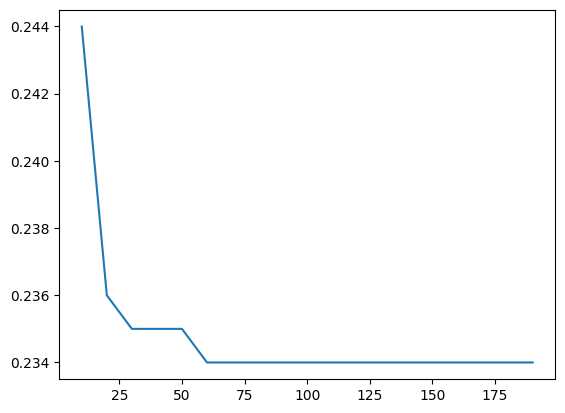

In [18]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

RMSE stop improving after n_estimators is around 60

## Question 4
Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
  - try different values of n_estimators from 10 till 200 (with step 10)
  - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [19]:
scores = []
for md in [10, 15, 20, 25]:
    rfr = RandomForestRegressor(n_estimators=0, max_depth=md, random_state=1, n_jobs=-1)

    for i in range(10, 200, 10):
        rfr.n_estimators = i
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        score = np.sqrt(((y_val - y_pred) ** 2).mean())

        scores.append((md, i, score))

    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

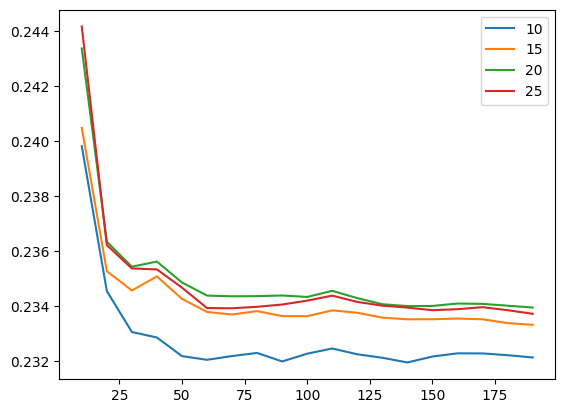

In [20]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

The Best max_depth is 10 and n_estimators is 130

## Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?

In [21]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
rf.feature_importances_

array([0.01156288, 0.01184622, 0.0668223 , 0.02852095, 0.14844544,
       0.13887527, 0.01247639, 0.01123539, 0.01079513, 0.00993119,
       0.01710259, 0.01281277, 0.01096071, 0.        , 0.01701071,
       0.01420735, 0.01610673, 0.0195187 , 0.01639213, 0.01333394,
       0.00988324, 0.00968597, 0.01005621, 0.00863697, 0.02357605,
       0.01229472, 0.01023678, 0.2459571 , 0.08171619])

In [23]:
df_importance = pd.DataFrame({
    'feature': dv.feature_names_,
    'importance': rf.feature_importances_
})
df_importance.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.245957
4,attendance_rate,0.148445
5,distance_to_school,0.138875
28,teacher_quality,0.081716
2,age,0.066822


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
```
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
```
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [4]:
import xgboost as xgb

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/riodpp/.pyenv/versions/3.10.0/envs/sandbox/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /Users/riodpp/.pyenv/versions/3.10.0/envs/sandbox/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/Users/riodpp/.pyenv/versions/3.10.0/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/riodpp/.pyenv/versions/3.10.0/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/Users/riodpp/.pyenv/versions/3.10.0/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/riodpp/.pyenv/versions/3.10.0/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)"]


In [25]:
import re

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

NameError: name 'xgb' is not defined

In [26]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

NameError: name 'dtrain' is not defined

In [27]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [28]:

%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

NameError: name 'xgb' is not defined

In [29]:
scores['eta=0.3'] = parse_xgb_output(output)

ValueError: not enough values to unpack (expected 3, got 1)

In [30]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

NameError: name 'xgb' is not defined

In [31]:
#@ STORING:
scores['eta=0.1'] = parse_xgb_output(output)

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()